# Alternative Data for Trading

## Library Imports

In [2]:
# Core Libraries for Data Handling and System Operations
import os
import re
import warnings
import pandas as pd

# Data Acquisition Libraries
import yfinance as yf
import kagglehub

# Natural Language Processing (NLP) Library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")


## Data Acquisition Tesla Stock Prices & Elon's Musk Tweets

In [3]:
# Define the stock ticker and the time period
ticker = 'TSLA'
start_date = '2020-01-01'
end_date = '2023-12-31'

# Download the data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Check the first 3 rows
print(stock_data.head(3))

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2020-01-02  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.104000  29.333332  29.364668  151995000


In [4]:
# Download latest version
path = kagglehub.dataset_download("dadalyndell/elon-musk-tweets-2010-to-2025-march")

## 1. Sentiment Analysis & Feature Engineering

In [10]:
#  Load, Filter, and Analyze Tweet Data
try:
    # Define the CSV file name
    csv_file_name = 'all_musk_posts.csv'
    # Construct the full path to the CSV file
    full_path_to_csv = os.path.join(path, csv_file_name)
    # Load the dataset
    tweets_df = pd.read_csv(full_path_to_csv, low_memory=False)

    # Convert 'createdAt' to a datetime object and create a 'date' column
    tweets_df['date'] = pd.to_datetime(tweets_df['createdAt'])
    # Filter the DataFrame to keep only tweets from a relevant time period
    tweets_df = tweets_df[tweets_df['date'] >= '2019-12-01'].copy()

    # Initialize the VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Define a function to clean the tweet text
    def clean_tweet(text):
        if not isinstance(text, str): return ""
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+', '', text)     # Remove mentions
        text = re.sub(r'#\w+', '', text)     # Remove hashtags
        return text.strip()

    # Specify the column containing the tweet text
    column_with_tweet_text = 'fullText'
    # Apply the cleaning function
    tweets_df['cleaned_tweet'] = tweets_df[column_with_tweet_text].apply(clean_tweet)
    # Apply the sentiment analysis function to get a sentiment score
    tweets_df['sentiment_score'] = tweets_df['cleaned_tweet'].apply(lambda text: analyzer.polarity_scores(text)['compound'])
except Exception as e:
    print(f"Error during the data loading/processing phase: {e}")


#  Feature Engineering and Data Merging
try:
    # Create a date-only column for grouping
    tweets_df['date_only'] = tweets_df['date'].dt.date
    # Group by date and calculate the average daily sentiment
    daily_sentiment = tweets_df.groupby('date_only')['sentiment_score'].mean().to_frame()
    daily_sentiment.rename(columns={'sentiment_score': 'avg_sentiment'}, inplace=True)

    
    #  Drop the MultiIndex level from the stock_data columns if it exists
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.droplevel(1)

    #  Ensure 'Date' is a column, not the index
    if 'Date' not in stock_data.columns:
        stock_data.reset_index(inplace=True)
    # ----------------------------------------

    # Create a date-only column in the stock data for merging
    stock_data['Date_only'] = pd.to_datetime(stock_data['Date']).dt.date

    # Merge the stock data with the daily sentiment data
    merged_df = pd.merge(stock_data, daily_sentiment, left_on='Date_only', right_index=True, how='inner')
    
    # Create the target variable: 1 if the next day's price went up, 0 otherwise
    merged_df['Price_Direction'] = (merged_df['Close'].shift(-1) > merged_df['Close']).astype(int)
    # Drop the last row as it will have a NaN value for Price_Direction
    merged_df.dropna(inplace=True)

    # Display the final DataFrame
    print("\n     FINAL DATAFRAME READY FOR MODELING ")
    print(merged_df[['Date', 'Close', 'avg_sentiment', 'Price_Direction']].head())

except Exception as e:
    print(f"An error occurred during the merge: {e}")


     FINAL DATAFRAME READY FOR MODELING 
        Date      Close  avg_sentiment  Price_Direction
2 2020-01-06  30.102667       0.375300                1
3 2020-01-07  31.270666       0.211277                1
4 2020-01-08  32.809334       0.488800                0
5 2020-01-09  32.089333       0.229400                0
6 2020-01-10  31.876667       0.124873                1


## 2. Baseline Model (RandomForest)

Training Set Size: 772 days
Test Set Size: 194 days

Model trained successfully!

Model Accuracy: 48.97%
Baseline Accuracy (always predict majority class): 52.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.45      0.45        92
           1       0.51      0.53      0.52       102

    accuracy                           0.49       194
   macro avg       0.49      0.49      0.49       194
weighted avg       0.49      0.49      0.49       194



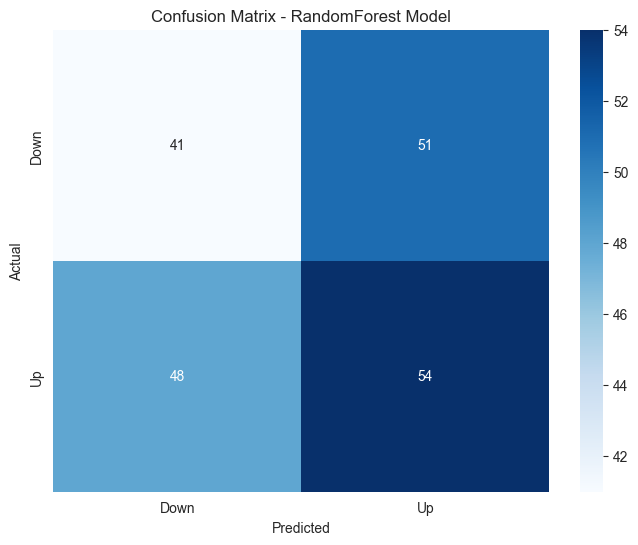

In [ ]:
# Define Features (X) and Target (y)
X = merged_df[['avg_sentiment']]
y = merged_df['Price_Direction']

# Chronological Data Split (Time-Series Split)
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training Set Size: {len(X_train)} days")
print(f"Test Set Size: {len(X_test)} days")

#  Create and Train the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("\nModel trained successfully!")

#  Make Predictions on the Test Set
predictions = model.predict(X_test)

#  Evaluate the Model's Performance
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy:.2%}")

# Comparative benchmark: What would be the accuracy if we always predicted the majority class?
baseline_accuracy = y_test.value_counts(normalize=True).max()
print(f"Baseline Accuracy (always predict majority class): {baseline_accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, predictions))

#  Visualize the Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RandomForest Model')
plt.show()

### Baseline Model: Results & Analysis

After training on 772 days of data, we evaluated the RandomForest model on a hold-out test set of 194 days.

**Key Observations:**

*   **Model Accuracy:** The model achieved a final accuracy of **48.97%**. This means it correctly predicted the stock's direction in slightly less than half of the test days.
*   **Baseline Comparison:** Crucially, this performance is below the **baseline accuracy of 52.58%**. The baseline represents a naive strategy of always guessing the most frequent outcome in the test set (in this case, 'Up'). A model must consistently beat this baseline to be considered useful.
*   **Confusion Matrix:** The matrix shows that the model has a relatively balanced (though incorrect) prediction rate. It correctly identified 41 'Down' days and 54 'Up' days. However, it also made 99 incorrect predictions.

**Conclusion:** The results from our baseline model suggest that using only the average daily sentiment from Elon Musk's tweets is not sufficient to create a predictive model that outperforms a simple guessing strategy. In the next step, we will explore if a more powerful algorithm and hyperparameter tuning can extract a stronger signal from the data.

## 3.1 Visual Analysis

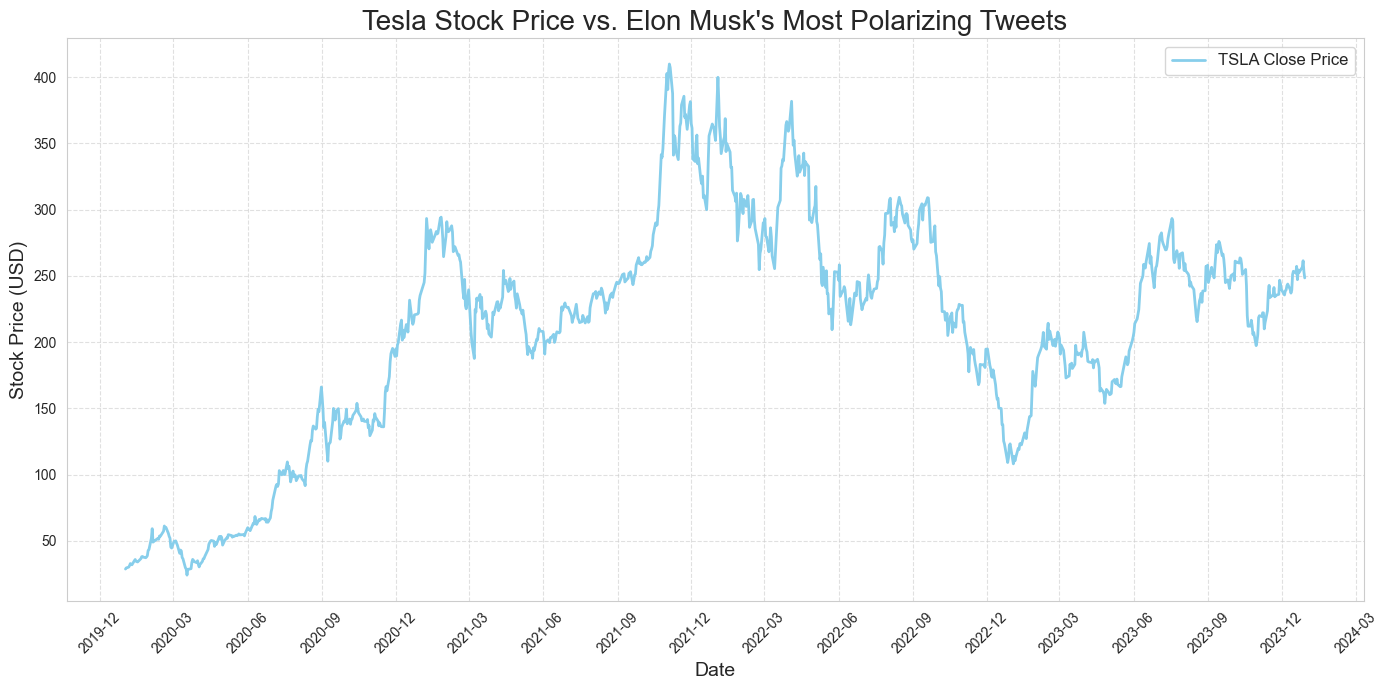

     Examples of Positive Tweets 
                                                                    fullText  \
date                                                                           
2019-12-29 22:29:55+00:00  @JohnnaCrider1 @vincent13031925 @boringcompany...   
2020-01-08 17:05:30+00:00  ♥️♥️ Tesla China Team ♥️♥️\n     Such amazing ...   
2020-02-04 09:28:18+00:00  This is mainly for staffing up 4 production sh...   

                           sentiment_score  
date                                        
2019-12-29 22:29:55+00:00           0.9771  
2020-01-08 17:05:30+00:00           0.9776  
2020-02-04 09:28:18+00:00           0.9657  

     Examples of Negative Tweets 
                                                                    fullText  \
date                                                                           
2019-12-30 08:00:14+00:00  @cleantechnica The less code, the better! 1 po...   
2020-01-10 23:26:33+00:00  @RQuiddich Every tank under pressure i

In [ ]:
# Find the most "extreme" tweets
tweets_for_plot = tweets_df.set_index('date')

# Find the index (i.e., the date) of the most positive tweet each month
most_positive_tweets = tweets_for_plot.resample('M')['sentiment_score'].idxmax().dropna()
# Find the index of the most negative tweet each month
most_negative_tweets = tweets_for_plot.resample('M')['sentiment_score'].idxmin().dropna()

#  Prepare the base stock price plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the closing price of the stock
ax.plot(stock_data['Date'], stock_data['Close'], label='TSLA Close Price', color='skyblue', linewidth=2)

#  Add markers for the tweets to the plot

# Add markers for the most POSITIVE tweets
for date in most_positive_tweets:
    # Find the stock price on that specific day
    price = stock_data.loc[stock_data['Date'] == date.date(), 'Close'].values
    if len(price) > 0:
        # Plot a green upward-pointing triangle
        # The complex label logic prevents creating multiple legend entries for the same item
        ax.plot(date, price[0], 'g^', markersize=12, label='Most Positive Tweet of Month' if 'Positive' not in ax.get_legend_handles_labels()[1] else "")
        
# Add markers for the most NEGATIVE tweets
for date in most_negative_tweets:
    # Find the stock price on that specific day
    price = stock_data.loc[stock_data['Date'] == date.date(), 'Close'].values
    if len(price) > 0:
        # Plot a red downward-pointing triangle
        ax.plot(date, price[0], 'rv', markersize=12, label='Most Negative Tweet of Month' if 'Negative' not in ax.get_legend_handles_labels()[1] else "")


# 4. Enhance the plot's appearance
ax.set_title('Tesla Stock Price vs. Elon Musk\'s Most Polarizing Tweets', fontsize=20)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Stock Price (USD)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12)

# Improve the formatting of the date axis
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Show a date tick every 3 months

plt.tight_layout()
plt.show()

# (Optional) Print some of the extreme tweets to see their content
print("     Examples of Positive Tweets ")
print(tweets_for_plot.loc[most_positive_tweets.head(3)][['fullText', 'sentiment_score']])

print("\n     Examples of Negative Tweets ")
print(tweets_for_plot.loc[most_negative_tweets.head(3)][['fullText', 'sentiment_score']])

### Analysis of the Initial Plot

The code correctly identifies the most extreme positive and negative tweets each month and generates the plot of the stock price. However, we immediately notice a significant issue: **the tweet markers are missing from the chart.**

**Diagnosis of the Problem:**
The reason for this is a logical mismatch between our two datasets. Stock markets operate on trading days (typically Monday to Friday), while tweets can be posted any day of the week, including weekends and holidays. Our current code attempts to match the tweet's date *exactly* with a trading day's price. If the month's most extreme tweet occurred on a Saturday, no price data exists for that date, and the marker is simply skipped.

**Solution:**
To fix this and create a meaningful visualization, we need to adjust our approach. Instead of looking for a price on the exact same day, we will find the price on the **next available trading day**. This better reflects how the market would react to news that occurred while it was closed. We will implement this solution in the next step using `pandas.merge_asof`.

## 3.2 Visual Analysis

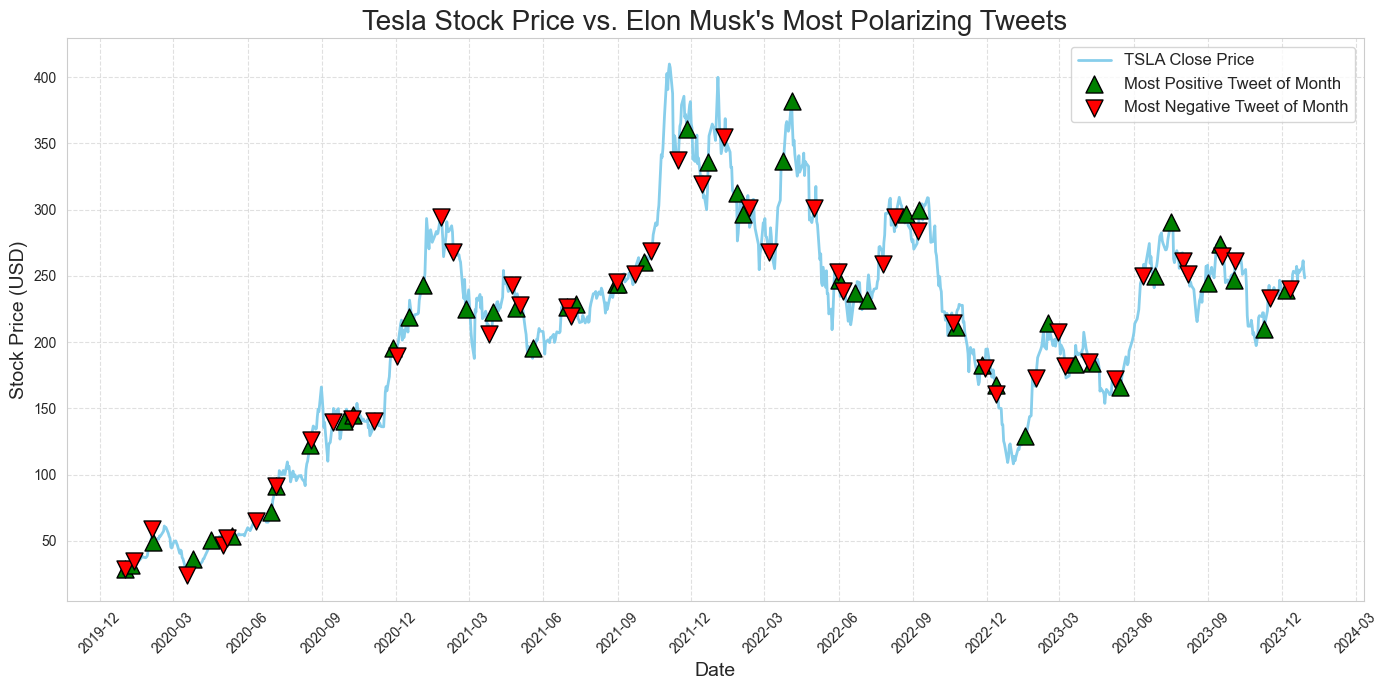

In [ ]:
stock_data_sorted = stock_data.copy()
stock_data_sorted['Date'] = pd.to_datetime(stock_data_sorted['Date'])
stock_data_sorted = stock_data_sorted.sort_values(by='Date')

tweets_sorted = tweets_df.copy()
tweets_sorted['date'] = pd.to_datetime(tweets_sorted['date'])
tweets_sorted = tweets_sorted.sort_values(by='date')

# Find the "Extreme" Tweets
tweets_for_plot = tweets_sorted.set_index('date')
most_positive_dates = tweets_for_plot.resample('M')['sentiment_score'].idxmax().dropna()
most_negative_dates = tweets_for_plot.resample('M')['sentiment_score'].idxmin().dropna()

# FIX FOR AMBIGUITY ERROR 
positive_tweets_df = pd.DataFrame({'date': most_positive_dates.values, 'sentiment': 'positive'})
negative_tweets_df = pd.DataFrame({'date': most_negative_dates.values, 'sentiment': 'negative'})


# Combine positive and negative tweets into a single DataFrame
extreme_tweets_df = pd.concat([positive_tweets_df, negative_tweets_df]).sort_values(by='date')

# Use merge_asof to find the price on the next available trading day
merged_plot_data = pd.merge_asof(
    left=extreme_tweets_df,
    right=stock_data_sorted,
    left_on='date',
    right_on='Date',
    direction='forward' 
)
merged_plot_data.dropna(inplace=True) 

#  Plot Everything Together
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the stock price line
ax.plot(stock_data['Date'], stock_data['Close'], label='TSLA Close Price', color='skyblue', linewidth=2, zorder=1)

# Plot markers for positive tweets
positive_points = merged_plot_data[merged_plot_data['sentiment'] == 'positive']
ax.scatter(positive_points['Date'], positive_points['Close'], c='green', marker='^', s=150, label='Most Positive Tweet of Month', zorder=2, edgecolors='black')

# Plot markers for negative tweets
negative_points = merged_plot_data[merged_plot_data['sentiment'] == 'negative']
ax.scatter(negative_points['Date'], negative_points['Close'], c='red', marker='v', s=150, label='Most Negative Tweet of Month', zorder=2, edgecolors='black')

#  Enhance the Plot's Appearance
ax.set_title("Tesla Stock Price vs. Elon Musk's Most Polarizing Tweets", fontsize=20)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Stock Price (USD)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=12)
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.tight_layout()
plt.show()

### Final Visualization: Mapping Tweets to Trading Days

This plot solves the weekend/holiday issue by mapping each extreme tweet to the stock price of the *next trading session*. This provides a much more realistic and informative view of the potential relationship.

**Observations and Insights from the Chart:**

*   **No Obvious Pattern:** At first glance, there is no simple, repeatable pattern such as "a very positive tweet always leads to a price jump." We can see green markers preceding both upward and downward movements, and the same is true for red markers. This visually confirms the conclusion from our machine learning models: sentiment alone is a noisy signal.
*   **Clusters During Volatility:** We can observe that periods of high stock price volatility, such as the run-up in late 2021 and the subsequent drop in 2022, often feature a dense cluster of both positive and negative "extreme" tweets. This suggests that while individual tweets may not be predictive, the overall volume and polarization of conversation could be correlated with market uncertainty.
*   **A Tool for Storytelling:** This visualization is the key takeaway of the project. It doesn't provide a magic trading algorithm, but it masterfully tells the story of the complex interplay between a major public figure and the valuation of their company. It allows a human analyst to spot interesting events and formulate new hypotheses for further investigation (e.g., "What happened around December 2022 that caused so many negative tweets and a price drop?").

**Final Conclusion:** While our quantitative models failed to find a predictive edge, this qualitative, visual analysis successfully highlights the nature of the relationship and serves as a powerful tool for exploratory data analysis.

## 4. Advanced Model (XGBoost Tuning)

      Starting Hyperparameter Tuning with GridSearchCV
Fitting 5 folds for each of 36 candidates, totalling 180 fits

      Evaluating the Optimal Model
Best Parameters Found: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}

Final Accuracy of the Optimized XGBoost Model: 49.48%
Baseline Accuracy (always predict majority class): 52.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.11      0.17        92
           1       0.51      0.84      0.64       102

    accuracy                           0.49       194
   macro avg       0.45      0.48      0.40       194
weighted avg       0.45      0.49      0.42       194



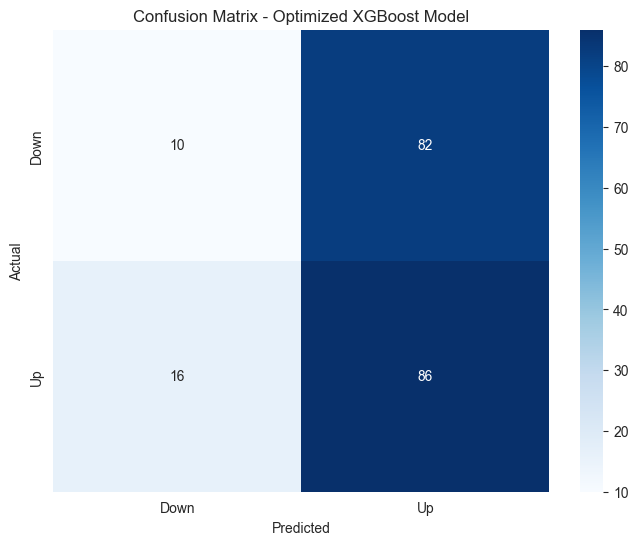

In [ ]:
# Define Features (X) and Target (y)
X = merged_df[['avg_sentiment']]
y = merged_df['Price_Direction']

# Split the data chronologically (same as before to maintain a final hold-out test set)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Define the grid of hyperparameters we want to test
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Use TimeSeriesSplit for cross-validation, which is appropriate for time-series data.
tscv = TimeSeriesSplit(n_splits=5)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=1, 
    n_jobs=-1  
)

# Train GridSearchCV to find the best model
print("      Starting Hyperparameter Tuning with GridSearchCV")
grid_search.fit(X_train, y_train)

# Evaluate the BEST model found
print("\n      Evaluating the Optimal Model")
print(f"Best Parameters Found: {grid_search.best_params_}")

# Get the best model identified by GridSearch
best_model = grid_search.best_estimator_

# Make predictions on the test set, which the model has never seen before
predictions = best_model.predict(X_test)

# Calculate the final accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nFinal Accuracy of the Optimized XGBoost Model: {accuracy:.2%}")

# Compare again with the baseline
baseline_accuracy = y_test.value_counts(normalize=True).max()
print(f"Baseline Accuracy (always predict majority class): {baseline_accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Visualize the Confusion Matrix for the optimized model
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Optimized XGBoost Model')
plt.show()

### Optimized Model: Results & Analysis

To explore potential improvements, we implemented a more advanced XGBoost model combined with hyperparameter tuning via GridSearchCV and a `TimeSeriesSplit` cross-validation strategy.

**Key Observations:**

*   **Marginal Accuracy Improvement:** The optimized model achieved a final accuracy of **49.48%**, a very slight improvement over the RandomForest model's 48.97%. However, it still fails to outperform the **baseline accuracy of 52.58%**.
*   **Prediction Bias:** The Confusion Matrix is highly revealing. The model developed a strong bias towards predicting the majority class ('Up'). It correctly identified 86 'Up' days but only 10 'Down' days.
*   **Low Recall for 'Down' Days:** The `recall` score for class 0 ('Down') is extremely low at **0.11**. This means the model only managed to capture 11% of the actual days the stock price fell. While it appears "better" at predicting 'Up' days, this is largely because it predicts 'Up' most of the time.

**Conclusion:** The hyperparameter tuning process effectively taught the model that predicting the majority class is the easiest way to maximize accuracy. While technically a more complex approach, the outcome reinforces our primary finding: the sentiment signal alone is too weak and noisy to provide a reliable predictive edge.

#  Project Conclusion 

This project was a comprehensive exploration into using alternative data—specifically the sentiment from Elon Musk's tweets—to predict the direction of Tesla's stock price.

### Key Takeaways

1.  **Sentiment is a Noisy Signal:** Our primary finding, confirmed by both a baseline RandomForest and a tuned XGBoost model, is that the average daily sentiment from tweets is not a sufficiently strong or reliable feature to consistently predict stock market movements. Both models performed worse than a simple baseline strategy.
2.  **The Importance of Context and Visualization:** While the quantitative models failed to produce a profitable strategy, the final visual analysis proved invaluable. The chart mapping extreme tweets onto the price history tells a compelling story about the *correlation* between social media activity and market volatility, even if a direct *causal* link is not evident. It highlights that the value of alternative data may lie more in providing qualitative context for human analysts than in direct algorithmic prediction.
3.  **Methodology Matters:** The project demonstrated a complete data science workflow: from automated data acquisition and NLP processing to rigorous, time-series-aware model evaluation and critical interpretation of the results. The process of identifying a problem (missing markers on the chart) and solving it (using `merge_asof`) is a key part of the data science practice.
